In [8]:
import random
import numpy as np
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import socket
import time

In [9]:
class inhomogenousMarkovChain:
    def __init__(self, order, temperature=1):
        self.order = order
        self.trans = defaultdict(lambda: defaultdict(int))
        self.start = defaultdict(int)
        self.temperature = temperature

    def add_sequence(self, sequence):
        order = self.order
        for i in range(len(sequence) - order):
            state = tuple(sequence[i:i+order])
            next_note = sequence[i+order]
            self.trans[state][next_note] += 1
            if i == 0:
                self.start[state] += 1

    def generate_sequence(self, length, start_state=None):
        current_state = start_state if start_state else self.choose_start_state()
        sequence = list(current_state)
        for _ in range(length - len(current_state)):
            next_note = self.choose_next_note(current_state)
            sequence.append(next_note)
            current_state = tuple(sequence[-self.order:])
        return sequence, tuple(sequence[-self.order:])

    def choose_start_state(self):
        total = sum(self.start.values())
        # random.choices doesn't like defaultdict
        r = random.uniform(0, total)
        for state, count in self.start.items():
            r -= count
            if r <= 0:
                return state
    
    def choose_next_note(self, state):
        sub_state = state[-self.order:]
        if sub_state in self.trans:
            probabilities = self.trans[sub_state]
            adjusted_probs = softmax_with_temperature(probabilities, self.temperature) # type: ignore
            return random.choices(list(adjusted_probs.keys()), 
                                weights=list(adjusted_probs.values()))[0]
        return random.choice(self.all_states[0])
    
    

In [10]:
def softmax_with_temperature(probabilities, temperature):
    log_probs = np.log(np.array(list(probabilities.values())))
    log_probs = log_probs / temperature
    probs = np.exp(log_probs) / np.sum(np.exp(log_probs))
    return dict(zip(probabilities.keys(), probs))

In [11]:
input_sequence = []
with open('..\\sources\\comb.txt', 'r') as file:
    input_sequence = file.read().split(',')
print(input_sequence)

['N0', 'R1', 'N0', 'R1', 'G1', 'N0', 'R1', 'N0', 'G1', 'R1', 'G1', 'N0', 'M1', 'G1', 'R1', 'S1', 'N0', 'R1', 'G1', 'M1', 'R1', 'G1', 'M1', 'P1', 'M1', 'D1', 'P1', 'M1', 'D1', 'N1', 'M1', 'D1', 'M1', 'N1', 'G1', 'M1', 'G1', 'N1', 'D1', 'P1', 'M1', 'R1', 'G1', 'N0', 'R1', 'S1', 'D0', 'N0', 'D0', 'S1', 'D0', 'N0', 'R1', 'G1', 'N0', 'R1', 'G1', 'G1', 'R1', 'G1', 'N0', 'R1', 'N0', 'G1', 'N0', 'R1', 'G1', 'M1', 'R1', 'M1', 'G1', 'G1', 'R1', 'M1', 'G1', 'M1', 'P1', 'G1', 'M1', 'P1', 'R1', 'S1', 'N0', 'R1', 'S1', 'N0', 'R1', 'G1', 'M1', 'P1', 'M1', 'P1', 'M1', 'P1', 'P1', 'M1', 'D1', 'P1', 'M1', 'P1', 'M1', 'D1', 'M1', 'N1', 'N1', 'D1', 'P1', 'M1', 'G1', 'G1', 'M1', 'D1', 'N1', 'M1', 'D1', 'N1', 'N1', 'D1', 'P1', 'M1', 'G1', 'R1', 'S1', 'N0', 'R1', 'S1', 'N0', 'R1', 'G1', 'N0', 'R1', 'M1', 'G1', 'M1', 'P1', 'M1', 'D1', 'P1', 'N1', 'D1', 'P1', 'M1', 'R1', 'G1', 'R1', 'N0', 'R1', 'D0', 'N0', 'S1', 'N0', 'R1', 'S1', 'N1', 'R1', 'G1', 'M1', 'P1', 'D1', 'N1', 'S2', 'S2', 'N1', 'D1', 'P1', 'M1', 'G1

In [12]:
def visualize_transitions(inhomogenousMarkovChain, top_n_transitions=2):
        chain = inhomogenousMarkovChain
        order = chain.order
        G = nx.DiGraph()
        for state, transitions in chain.trans.items():
            if len(state) == order:
                state_str = ''.join(state)
                total = sum(transitions.values())
                top_transitions = sorted(transitions.items(), key=lambda x: x[1], reverse=True)[:top_n_transitions]
                
                for next_note, count in top_transitions:
                    probability = count / total
                    next_state = state[1:] + (next_note,)
                    next_state_str = ''.join(next_state)
                    
                    G.add_edge(state_str, next_state_str, weight=probability, order=order)
        
        pos = nx.spring_layout(G, k=0.9, iterations=50)
        
        plt.figure(figsize=(12, 8))
        
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=0.8)
        
        edges = G.edges()
        weights = [G[u][v]['weight'] for u, v in edges]
        nx.draw_networkx_edges(G, pos, edge_color='gray', width=[w * 5 for w in weights], arrows=True, arrowsize=20)
        
        nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
        
        edge_labels = nx.get_edge_attributes(G, 'weight')
        edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        
        plt.title(f"Markov Chain Transition Probabilities - {chain.order} order, top {top_n_transitions} transitions")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [13]:
# midi dictionary
d = {'D0': 7,
 'N0': 9,
 'S1': 12,
 'R1': 14,
 'G1': 16,
 'M1': 18,
 'P1': 19,
 'D1': 21,
 'N1': 23,
 'S2': 24,
 'R2': 26,
 'G2': 28}

origin = 48
for key,value in d.items():
    d[key] = d[key] + origin

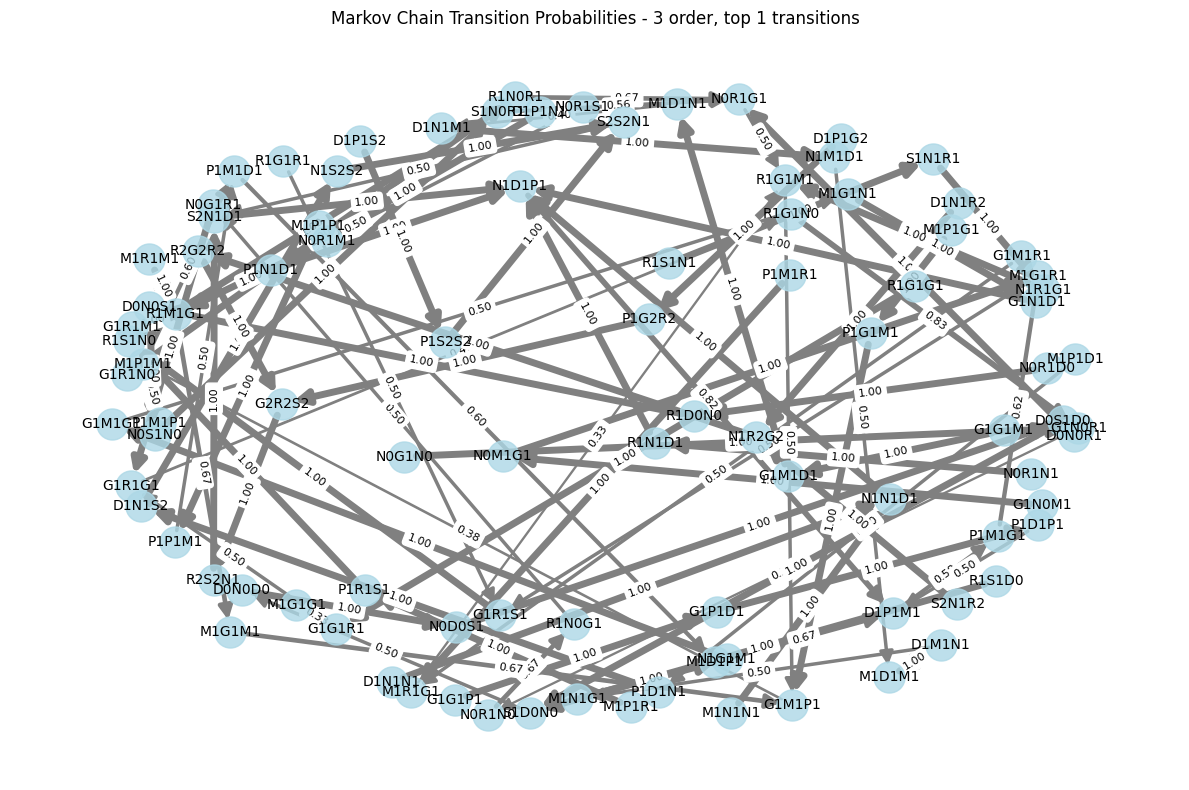

UDP target IP: 127.0.0.1
UDP target port: 3333
sent:      57
sent:      62
sent:      57
sent:      64
sent:      57
sent:      62
sent:      64
sent:      57
sent:      62
sent:      57
sent:      62
sent:      55
sent:      57
sent:      60
sent:      57
sent:      62
sent:      60
sent:      55
sent:      57
sent:      55
sent:      60
sent:      55
sent:      57
sent:      55
sent:      60
sent:      55
sent:      57
sent:      55
sent:      60
sent:      55
sent:      57
sent:      55
sent:      60


KeyboardInterrupt: 

In [14]:
def kala():
    markov_chain = inhomogenousMarkovChain(order = 3, temperature= 4)
    markov_chain.add_sequence(input_sequence)
    visualize_transitions(markov_chain,top_n_transitions=1)

    UDP_IP = "127.0.0.1"
    UDP_PORT = 3333
    print("UDP target IP: %s" % UDP_IP)
    print("UDP target port: %s" % UDP_PORT)
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    
    p = None
    while True:
        generated_sequence, p = markov_chain.generate_sequence(100, p)
        pure_sequence = [d[i] for i in generated_sequence]
        pause=.3
        for i in pure_sequence:
            sock.sendto(i.to_bytes(8, byteorder="big"), (UDP_IP, UDP_PORT))
            print("sent:     ", i)
            time.sleep (pause)
        
kala()